In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F

# ========== 1. Device and Data Path ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = 'Covid19-dataset'

In [3]:
# ========== 2. Transforms ==========
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
# ========== 3. Dataset and Dataloaders ==========
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print("Classes:", class_names)

Train size: 251, Test size: 67
Classes: ['Covid', 'Normal', 'Viral Pneumonia']


In [5]:
# ========== 4. Model Setup: ResNet50 Fine-tuned ==========
model = models.resnet50(pretrained=True)

# Modify first conv layer to accept grayscale input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last block and fc for fine-tuning
for param in model.layer4.parameters():
    param.requires_grad = True

# Update final classification layer
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 3)  # 3 classes
)

model = model.to(device)

/opt/anaconda3/envs/healthcareProject/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/healthcareProject/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# ========== 5. Loss, Optimizer, Scheduler ==========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)


In [8]:
# ========== 6. Training Loop ==========
num_epochs = 20
best_acc = 0.0
train_losses, val_losses = [], []  # Added val_losses
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ---- Validation ----
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_running_loss / len(test_loader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/20] - Train Loss: 0.4319, Val Loss: 4.5179, Train Acc: 0.8406, Val Acc: 0.4627
Epoch [2/20] - Train Loss: 0.3000, Val Loss: 1.6234, Train Acc: 0.8884, Val Acc: 0.6119
Epoch [3/20] - Train Loss: 0.2579, Val Loss: 1.5293, Train Acc: 0.9084, Val Acc: 0.5373
Epoch [4/20] - Train Loss: 0.1546, Val Loss: 1.3658, Train Acc: 0.9442, Val Acc: 0.5522
Epoch [5/20] - Train Loss: 0.1973, Val Loss: 0.3107, Train Acc: 0.9243, Val Acc: 0.8209
Epoch [6/20] - Train Loss: 0.1507, Val Loss: 0.2590, Train Acc: 0.9323, Val Acc: 0.8955
Epoch [7/20] - Train Loss: 0.1384, Val Loss: 0.1193, Train Acc: 0.9442, Val Acc: 0.9552
Epoch [8/20] - Train Loss: 0.1957, Val Loss: 0.0668, Train Acc: 0.9323, Val Acc: 0.9701
Epoch [9/20] - Train Loss: 0.2184, Val Loss: 0.1112, Train Acc: 0.9323, Val Acc: 0.9403
Epoch [10/20] - Train Loss: 0.1227, Val Loss: 0.0707, Train Acc: 0.9522, Val Acc: 0.9701
Epoch [11/20] - Train Loss: 0.1623, Val Loss: 0.0998, Train Acc: 0.9323, Val Acc: 0.9552
Epoch [12/20] - Train Loss: 0.

In [9]:
# ========== 7. Load Best Model ==========
model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [10]:
# ========== 8. Final Evaluation ==========
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nTest Accuracy: {test_acc:.4f}")


Test Accuracy: 1.0000


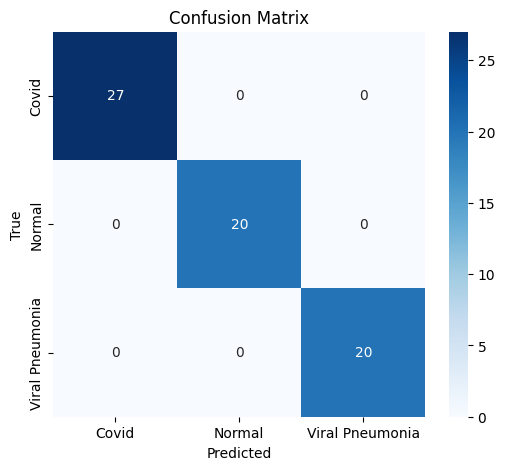

In [11]:
# ========== 9. Confusion Matrix ==========
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


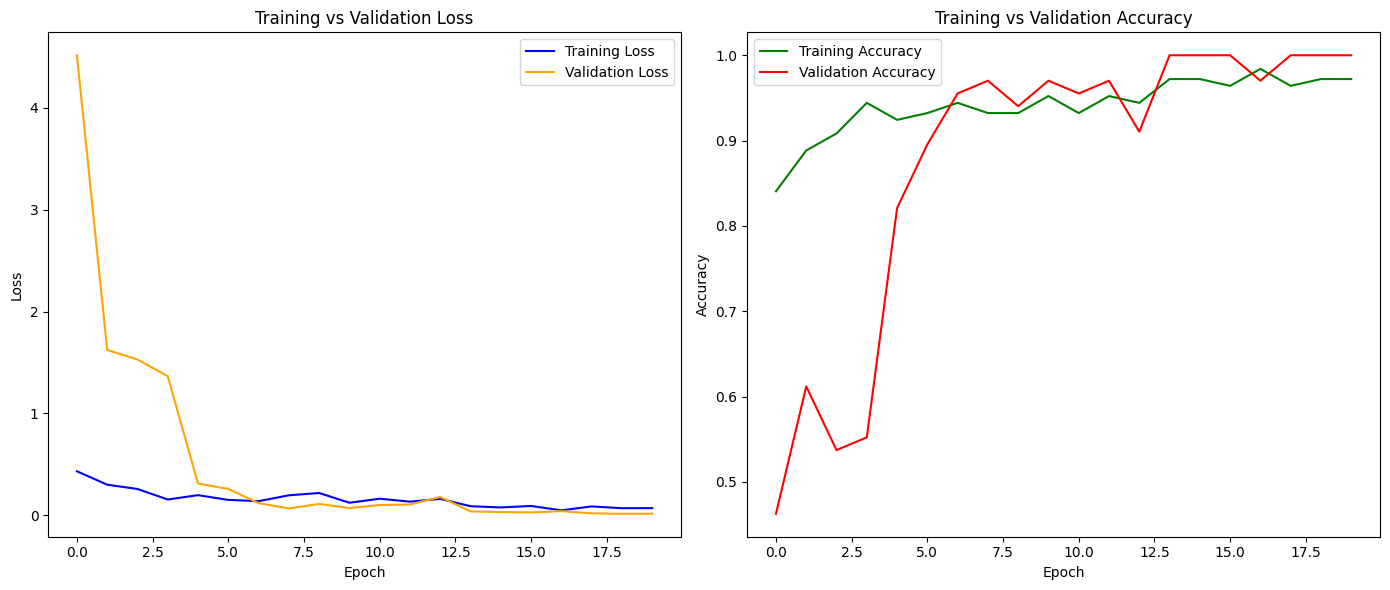

In [13]:
# ========== 10. Plot Accuracy & Loss ==========

plt.figure(figsize=(14, 6))

# ---- Loss Plot ----
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# ---- Accuracy Plot ----
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
